In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
import tensorflow_datasets as tfds

In [4]:
tfds.disable_progress_bar()

In [5]:
import numpy as np

print(tf.__version__)

2.1.0


In [6]:
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

In [7]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=0.1.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    urls=['http://ai.stanford.edu/~amaas/data/sentiment/'],
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts

In [8]:
info.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})

In [9]:
encoder = info.features['text'].encoder

In [10]:
info.splits

{'test': <tfds.core.SplitInfo num_examples=25000>,
 'train': <tfds.core.SplitInfo num_examples=25000>,
 'unsupervised': <tfds.core.SplitInfo num_examples=50000>}

In [11]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [12]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]


In [13]:
original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

assert original_string == sample_string

The original string: "Hello TensorFlow."


In [14]:
for ts in encoded_string:
  print ('{} ----> {}'.format(ts, encoder.decode([ts])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [15]:
for train_example, train_label in train_data.take(1):
    print('Original text:', encoder.decode(train_example[:20]))
    print('Encoded text:', train_example[:20].numpy())
    print('Label:', train_label.numpy())

Original text: As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of 
Encoded text: [ 249    4  277  309  560    6 6639 4574    2   12   31 7759 3525 2128
   93 2306   43 2312 2527    6]
Label: 1


In [16]:
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32, train_data.output_shapes))

test_batches = (
    test_data
    .padded_batch(32, train_data.output_shapes))

In [17]:
for example_batch, label_batch in train_batches.take(4):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)

Batch shape: (32, 742)
label shape: (32,)
Batch shape: (32, 1290)
label shape: (32,)
Batch shape: (32, 1414)
label shape: (32,)
Batch shape: (32, 988)
label shape: (32,)


In [18]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16, mask_zero=True),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/10
782/782 [==============================] - 7s 9ms/step - loss: 0.6288 - accuracy: 0.7353 - val_loss: 0.5393 - val_accuracy: 0.8042
Epoch 2/10
782/782 [==============================] - 6s 7ms/step - loss: 0.4557 - accuracy: 0.8424 - val_loss: 0.4070 - val_accuracy: 0.8510
Epoch 3/10
782/782 [==============================] - 6s 7ms/step - loss: 0.3529 - accuracy: 0.8762 - val_loss: 0.3437 - val_accuracy: 0.8615
Epoch 4/10
782/782 [==============================] - 6s 7ms/step - loss: 0.2976 - accuracy: 0.8942 - val_loss: 0.3092 - val_accuracy: 0.8719
Epoch 5/10
782/782 [==============================] - 5s 7ms/step - loss: 0.2620 - accuracy: 0.9074 - val_loss: 0.2881 - val_accuracy: 0.8813
Epoch 6/10
782/782 [==============================] - 5s 7ms/step - loss: 0.2362 - accuracy: 0.9163 - val_loss: 0.2757 - val_accuracy: 0.8833
Epoch 7/10
782/782 [==============================] - 5s 7ms/step - loss: 0.2160 - accuracy: 0.9230 - val_loss: 0.2666 - val_accuracy: 0.8823
Epoch 

In [21]:
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

    782/Unknown - 3s 4ms/step - loss: 0.2974 - accuracy: 0.8792Loss:  0.2974038736756577
Accuracy:  0.87924


In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [23]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']


In [24]:
epochs = range(1, len(acc) + 1)

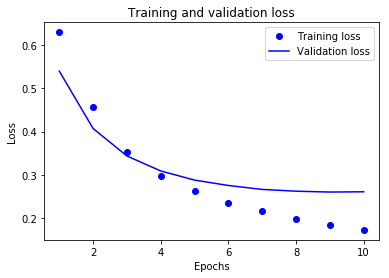

In [25]:
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

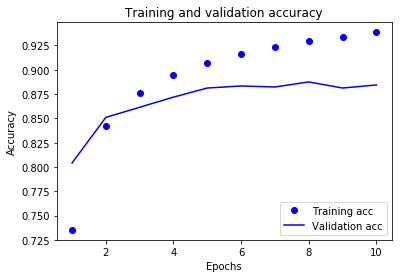

In [26]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()